dim(X) =  (5000, 400)  dim(y) =  (5000, 1)


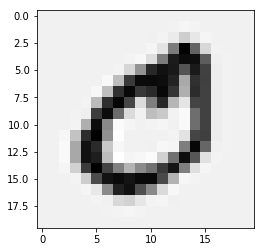

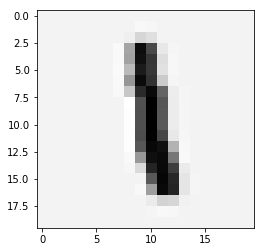

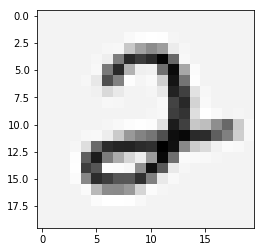

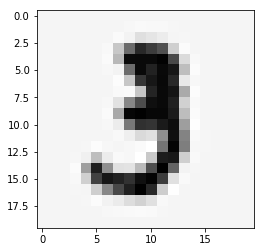

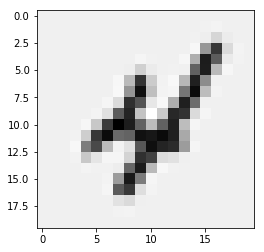

Shape of the data (including X and Y) for random permutation:  (5000, 401)
Before preprocessing, shapes of X_train, X_test, Y_train and Y_test:  (400, 3750) (400, 1250) (1, 3750) (1, 1250)
After preprocessing, shapes of X_train and Y_train:  (400, 3750) (10, 3750)
After preprocessing, shapes of X_test and Y_test:  (400, 1250) (10, 1250)


In [1]:
import numpy as np
import matplotlib.pyplot as pt
import scipy.io as sio
from sklearn.metrics import accuracy_score, classification_report
# Loading data
mat = sio.loadmat(r"C:\Users\Shivam\Desktop\a.mat")
X = np.array(mat['X'])
Y = np.array(mat['y'])
print("dim(X) = ", X.shape, " dim(y) = ", Y.shape)

# Displaying some of the samples
def display_digit(OneSam):
    OneSam = OneSam.reshape(20, 20).transpose()
    pt.imshow(255-OneSam, cmap = 'gray')
    pt.show()
    
for i in (1, 501, 1001, 1501, 2001):
    display_digit(X[i])

# Splitting data into training and test data
data = np.concatenate((X, Y), axis = 1)
print("Shape of the data (including X and Y) for random permutation: ", data.shape)
data = np.random.permutation(data)
mid = (int) ((3*data.shape[0]) / 4)
X_train, Y_train = data[:mid, :400].T, data[:mid, 400:].T
X_test, Y_test = data[mid:, :400].T, data[mid:, 400:].T
print("Before preprocessing, shapes of X_train, X_test, Y_train and Y_test: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Preprocessing output for training data
Y_train_p = np.zeros((10, Y_train.shape[1]))
for i in range(Y_train.shape[1]):
    index = (int)(Y_train[0][i] - 1)
    Y_train_p[index][i] = 1
print("After preprocessing, shapes of X_train and Y_train: ", X_train.shape, Y_train_p.shape)

# Preprocessing output for test data
Y_test_p = np.zeros((10, Y_test.shape[1]))
for i in range(Y_test.shape[1]):
    index = (int)(Y_test[0][i] - 1)
    Y_test_p[index][i] = 1
print("After preprocessing, shapes of X_test and Y_test: ", X_test.shape, Y_test_p.shape)

#Some useful functions
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z 
    return A, cache

def relu(Z):

    A = np.maximum(0,Z) 
    cache = Z 
    return A, cache


def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [ ]:
class NeuralNetwork:
    
    parameters = {}
    grads = {}
    costs = []
    costs_label = []
    
    def __init__(self, X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, print_cost_frequency = 500, parameters_init_factor = 0.01):
        
        # Initializing the parameters
        self.parameters = self.initialize_parameters(layers_dims, parameters_init_factor)

        for i in range(0, num_iterations):
            # Forward Propagation
            AL, caches = self.forward_propagate(X, self.parameters)
            cost = self.compute_cost(AL, Y)

            # Backward propagation.
            grads = self.backward_propagate(AL, Y, caches)

            # Updating the parameters
            self.parameters = self.update_parameters(self.parameters, grads, learning_rate)

            if i % print_cost_frequency == 0:
                
                # Saving Costs At Regular Intervals
                self.costs.append(cost)
                self.costs_label.append(i)
                
                # Printing Cost If Demanded
                if print_cost:
                    print("Cost After {} Iterations: {}".format(i, cost))
        
    def initialize_parameters(self, layers_dims, parameters_init_factor):
        
        L = len(layers_dims)
        # layers_dims starts with dimension of the input layer and ends with the dimension of the output layer

        for l in range(1, L):
            self.parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])*parameters_init_factor
            self.parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
            
        return self.parameters
    
    def forward_propagate(self, X, parameters):
        
        # A cache is to be returned, containing all the Z's, A's(activations) and the parameters 
        caches = []
        A = X
        L = len(parameters) // 2   # Since 'parameters' contain both wieghts and biases               
        
        for l in range(1, L):
            A_prev = A 
            A, cache = self.linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], 'relu')
            caches.append(cache)
            
        AL, cache = self.linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], 'sigmoid')
        caches.append(cache)
        
        return AL, caches
    
    def linear_activation_forward(self, A_prev, W, b, activation):
        
        Z, linear_cache = np.dot(W, A_prev) + b, (A_prev, W, b)
        
        if activation == "sigmoid": 
            A, activation_cache = sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = relu(Z)
            
        cache = (linear_cache, activation_cache)

        return A, cache
    
    def compute_cost(self, AL, Y):
        
        m = Y.shape[1]
        
        cost = - np.sum(np.sum(Y*np.log(AL) + (1 - Y)*np.log(1 - AL))) / m

        cost = np.squeeze(cost)      # To make sure that cost's shape is what we expect (e.g. this turns [[17]] into 17).
        
        return cost
    
    def backward_propagate(self, AL, Y, caches):
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

        # Initializing the backpropagation
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        # Backpropagation for the output layer (sigmoid activation)
        current_cache = caches[L - 1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linear_activation_backward(dAL, current_cache, activation = 'sigmoid') 


        for l in reversed(range(L-1)):
            # Backpropagation for the hidden layers (ReLU activation)
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(grads['dA' + str(l + 2)], current_cache, activation = 'relu')
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
    
    def linear_activation_backward(self, dA, cache, activation):
        
        linear_cache, activation_cache = cache
        A_prev, W, b = linear_cache[0], linear_cache[1], linear_cache[2]
        m = A_prev.shape[1]
        
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
            
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
        
        dA_prev, dW, db = np.dot(W.T, dZ), np.dot(dZ, A_prev.T) / m, np.sum(dZ, axis = 1, keepdims = True) / m 
     
        return dA_prev, dW, db
    
    
    def update_parameters(self, parameters, grads, learning_rate):   

        L = len(parameters) // 2    # Since parameters contain both Weights and Biases

        for l in range(1, L + 1):
            self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - grads["dW" + str(l)]*learning_rate
            self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - grads["db" + str(l)]*learning_rate

        return parameters
    
    
    def predict(self, X):
        
        y_pred = self.forward_propagate(X, self.parameters)[0]
        y_pred_ret = np.zeros(y_pred.shape)
        
        for i in range(y_pred.shape[1]):
            
            max_index, max_value = 0, y_pred[0][i]
            
            for j in range(1, y_pred.shape[0]):
                if(y_pred[j][i] > max_value):
                    max_value = y_pred[j][i]
                    max_index = j
                    
            y_pred_ret[max_index][i] = 1
                
        return y_pred_ret
    
    def plotCost(self):
        
        pt.plot(self.costs, self.costs_label, color = 'green')
        

In [ ]:
myNN = NeuralNetwork(X_train, Y_train_p, layers_dims = (X_train.shape[0], 30, 10), learning_rate = 0.1, num_iterations = 5000, print_cost=True, print_cost_frequency = 100, parameters_init_factor = 0.01)

Cost After 0 Iterations: 6.93062353797494
Cost After 100 Iterations: 2.721806373909184
Cost After 200 Iterations: 1.6135589367385028
Cost After 300 Iterations: 1.14839226622042
Cost After 400 Iterations: 0.9243296861794867
Cost After 500 Iterations: 0.7877552781140158
Cost After 600 Iterations: 0.702150635228113
Cost After 700 Iterations: 0.6435924465114172
Cost After 800 Iterations: 0.5981172292608863
Cost After 900 Iterations: 0.5616162377000397
Cost After 1000 Iterations: 0.531366142390077
Cost After 1100 Iterations: 0.505478576185716
Cost After 1200 Iterations: 0.48273566165282733
Cost After 1300 Iterations: 0.4623394453700848
Cost After 1400 Iterations: 0.4437647987641383
Cost After 1500 Iterations: 0.4264925072899672
Cost After 1600 Iterations: 0.4102064809056809
Cost After 1700 Iterations: 0.39517058331683613
Cost After 1800 Iterations: 0.38108924598182714
Cost After 1900 Iterations: 0.3678011683620496
Cost After 2000 Iterations: 0.35531672349867643
Cost After 2100 Iterations: 0

In [ ]:
myNN.plotCost()
y_test_pred = myNN.predict(X_test)
y_train_pred = myNN.predict(X_train)

In [ ]:
print(Y_train_p.shape, y_train_pred.shape)

In [ ]:
print("Accuracy on training set: ", accuracy_score(Y_train_p.T, y_train_pred.T)*100)

In [ ]:
print("Accuracy on test set: ", accuracy_score(Y_test_p.T, y_test_pred.T)*100)

In [ ]:
print("Classification Report: \n", classification_report(Y_test_p.T, y_test_pred.T))